In [1]:
# Create a dummy config.yaml file for demonstration purposes
import yaml
import os
import torch

config_data = {
    'dataset': {
        'batch_size': 64,
        'validation_split': 0.2,
        'download': True,
        'shuffle': True,
        'path': './data'
    },
    'training': {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'learning_rate': 0.001,
        'epochs': 5
    }
}

os.makedirs('configs', exist_ok=True)
with open('configs/config.yaml', 'w') as f:
    yaml.dump(config_data, f)
    
print("✅ Configuration file 'configs/config.yaml' created.")

✅ Configuration file 'configs/config.yaml' created.


In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import json
import random

# Helper function to load configuration
def get_config(path="configs/config.yaml"):
    with open(path, "r") as f:
        config = yaml.safe_load(f)
    return config

# Helper function for reproducibility
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

In [3]:
def get_mnist_dataloaders(config):
    """
    Returns train, validation, and test DataLoaders for MNIST
    """
    # Config params
    batch_size = config['dataset']['batch_size']
    val_split = config['dataset']['validation_split']
    download = config['dataset']['download']
    shuffle = config['dataset']['shuffle']
    path = config['dataset']['path']

    # 1. Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # 2. Load full training dataset
    full_train = datasets.MNIST(root=path, train=True, transform=transform, download=download)

    # 3. Create train/validation split
    val_size = int(len(full_train) * val_split)
    train_size = len(full_train) - val_size
    train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

    # 4. Test dataset
    test_dataset = datasets.MNIST(root=path, train=False, transform=transform, download=download)

    # 5. DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Example usage
config = get_config()
train_loader, val_loader, test_loader = get_mnist_dataloaders(config)
print(f"✅ DataLoaders created. Train samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}, Test samples: {len(test_loader.dataset)}")

100%|██████████| 9.91M/9.91M [01:07<00:00, 146kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 85.6kB/s]
100%|██████████| 1.65M/1.65M [00:12<00:00, 132kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 60.8kB/s]

✅ DataLoaders created. Train samples: 48000, Validation samples: 12000, Test samples: 10000


In [6]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout (regularization)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        return x

# Example usage
model = CNN()
print("✅ CNN model defined.")

✅ CNN model defined.


In [7]:
def evaluate_validation(model, dataloader, device):
    """
    Runs evaluation on validation data.
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_model():
    config = get_config()
    device = torch.device(config['training']['device'])
    
    train_loader, val_loader, _ = get_mnist_dataloaders(config)

    model = CNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['training']['learning_rate'])

    best_val_acc = 0.0
    for epoch in range(config['training']['epochs']):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['training']['epochs']}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}] Training Loss: {running_loss/len(train_loader):.4f}, Training Acc: {train_acc:.2f}%")

        val_acc = evaluate_validation(model, val_loader, device)
        print(f"Validation Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            os.makedirs("checkpoints", exist_ok=True)
            torch.save(model.state_dict(), "checkpoints/best_model.pth")
            print("✅ Saved new best model!")

    print("Training complete.")
    
train_model()

Epoch [1] Training Loss: 0.2534, Training Acc: 92.28%
Validation Acc: 98.19%
✅ Saved new best model!


Epoch [2] Training Loss: 0.0917, Training Acc: 97.35%
Validation Acc: 98.32%
✅ Saved new best model!


Epoch [3] Training Loss: 0.0676, Training Acc: 97.98%
Validation Acc: 98.76%
✅ Saved new best model!


Epoch [4] Training Loss: 0.0547, Training Acc: 98.32%
Validation Acc: 98.96%
✅ Saved new best model!


Epoch [5] Training Loss: 0.0456, Training Acc: 98.65%
Validation Acc: 98.89%
Training complete.


Classification Report:

              precision    recall  f1-score   support

           0     0.9889    0.9959    0.9924       980
           1     0.9870    1.0000    0.9934      1135
           2     0.9903    0.9932    0.9918      1032
           3     0.9931    0.9950    0.9941      1010
           4     0.9908    0.9898    0.9903       982
           5     0.9921    0.9910    0.9916       892
           6     0.9948    0.9896    0.9922       958
           7     0.9873    0.9864    0.9869      1028
           8     0.9917    0.9846    0.9882       974
           9     0.9930    0.9812    0.9870      1009

    accuracy                         0.9908     10000
   macro avg     0.9909    0.9907    0.9908     10000
weighted avg     0.9908    0.9908    0.9908     10000

✅ Confusion matrix saved at results/confusion_matrix.png
✅ Metrics saved at results/metrics.json


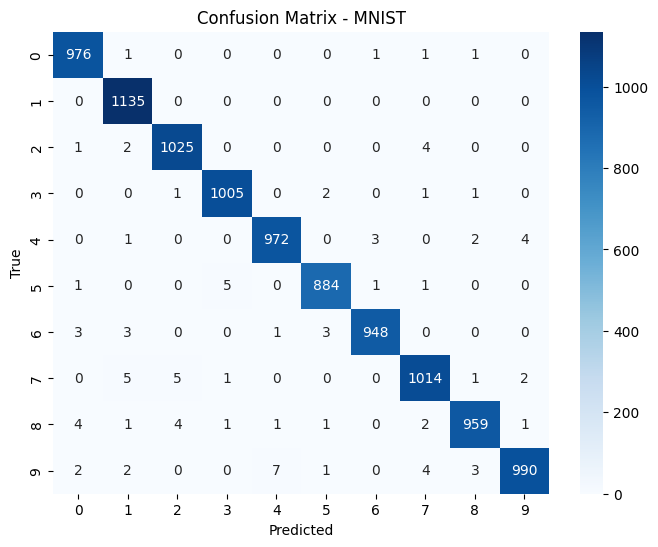

In [8]:
def evaluate_model():
    config = get_config()
    checkpoint_path = "checkpoints/best_model.pth"
    
    if not os.path.exists(checkpoint_path):
        print("❌ Error: Checkpoint file not found. Please run the training cell first.")
        return

    device = torch.device(config['training']['device'])
    _, _, test_loader = get_mnist_dataloaders(config)

    model = CNN(num_classes=10).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:\n")
    report = classification_report(all_labels, all_preds, digits=4)
    print(report)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - MNIST")

    os.makedirs("results", exist_ok=True)
    plt.savefig("results/confusion_matrix.png")
    print("✅ Confusion matrix saved at results/confusion_matrix.png")

    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "classification_report": classification_report(all_labels, all_preds, digits=4, output_dict=True)
    }

    os.makedirs("results", exist_ok=True)
    with open("results/metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

    print("✅ Metrics saved at results/metrics.json")
    
evaluate_model()